# Adversarial Perturbations

## Checking Avilable GPU

In [26]:
!nvidia-smi

Thu Mar 16 11:19:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.05    Driver Version: 525.85.05    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   52C    P2   118W / 350W |   2522MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing requirements

In [27]:
# pytorch libs
import torch
from torch import nn
import torchaudio
import torchvision

# matplot libs
import matplotlib.pyplot as plt

# numpy
import numpy as np

# torch metrics
try:
  import torchmetrics
except:
  !pip3 -q install torchmetrics
import torchmetrics
from torchmetrics.classification import Accuracy

try:
  import torchinfo
except:
  !pip3 -q install torchinfo
finally:
  from torchinfo import summary

try:
  import torchattacks
except:
  !pip3 -qq install torchattacks
finally:
  import torchattacks

try:
  import gtts
except:
  !pip3 -qq install gtts
finally:
  import gtts

from tqdm.auto import tqdm

## device agnostic code

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

## Getting Dataset with pytorch

### Downloading Dataset

In [29]:
from torchvision import transforms

image_trasform = transforms.Compose(
    [
        # transforms.Grayscale(num_output_channels=1), # converting to 1 channel
        transforms.ToTensor()
    ]
)

train_dataset = torchvision.datasets.CIFAR10(
    root="data/", download=True, train=True, transform=image_trasform
)

test_dataset = torchvision.datasets.CIFAR10(
    root="data/", download=True, train=False, transform=image_trasform
)
train_dataset, test_dataset


Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: data/
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: data/
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
            ))

### Vis. dataset (train dataset)

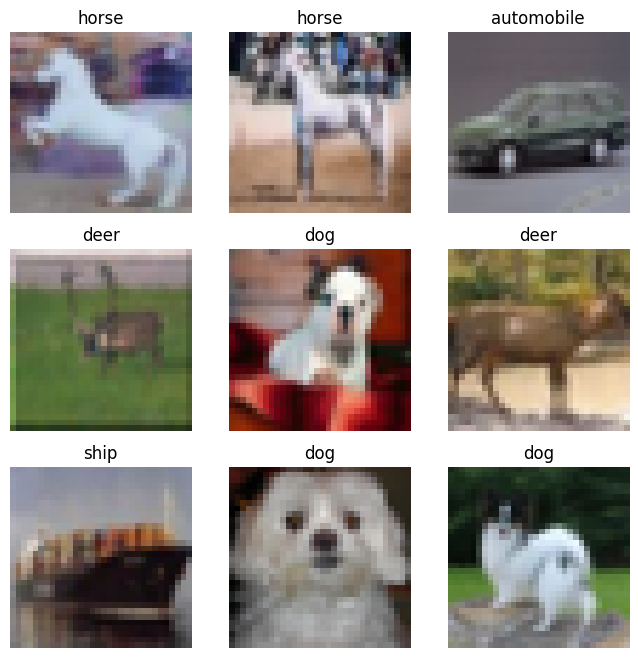

In [30]:
# randomly ploting image samples from the grayscale dataset
labels_map = test_dataset.class_to_idx  # getting class -> index map
labels_map = dict(map(reversed, labels_map.items()))  # inverting dict
# print(labels_map)

figure = plt.figure(figsize=(8, 8))  # fixing plotsize
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(
        len(train_dataset), size=(1,)
    )  # randomely selecting one image sample from the image index
    img, label = train_dataset[sample_idx]  # getting image and label of selected index
    # sub plot code
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(
        img.permute(1, 2, 0)
    )  # NOTE:- Color map is gray because we're converting imgae to grayscale / changing channel to HWC for color image
    # sub plot code ends
plt.show()


### Converting dataset to dataloader

In [31]:
import os

# hyper parms. for dataloader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()  # no. of avilable cpu cores

# train dataloader
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

# test dataloader
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

print(f"Numbers of Batches in Train Dataloader: {len(train_dataloader)}")
print(f"Numbers of Batches in Test Dataloader: {len(test_dataloader)}")
# train_dataloader,test_dataloader


Numbers of Batches in Train Dataloader: 1563
Numbers of Batches in Test Dataloader: 313


## Defining model

In [32]:
class BasicCNN(nn.Module):
    def __init__(self, in_features: int, hidden_units: int, out_features: int) -> None:
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_features,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),  # conv layer 1
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),  # conv layer 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),  # conv layer 3
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential( # classifier layer
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 8 * 8, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=out_features),
        )

    def forward(self,x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block1(x)
        # print(f"conv_1 out shape : {x.shape}")
        x = self.conv_block2(x)
        # print(f"conv_2 out shape : {x.shape}")
        x = self.classifier(x)
        return x
        

## Models Training

### set seeds function

In [33]:
### set seed function
def set_seed(seed: int = 42):
    """
    sets mannual seeds for both cpu and cuda
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


### making training, testing steps, train model functions & ploting function

#### train step

In [34]:
def training_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    device: str,
):
    """
    Desc:
      funtion to perform traning step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      optimizer (torch.optim.Optimizer): Optimizer Function (object) of your choice
      device (str): Torch Device "CPU/GPU"
    Returns:
      train_loss (float), train_acc (float): training loss and training accuracy for one EPOCH
    """
    model.train()  # putting model in traing model

    train_loss, train_acc = 0, 0  # initlizing loss and acc. for the epoch

    # print(type(model.parameters()))
    for (X, y) in dataloader:  # loop in batches
        # model_parms_before_forward_pass = np.array([x.detach().numpy() for x in model.parameters()].copy())
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

        # 1. forward pass
        y_pred_logits = model(X)

        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backword
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        # model_parms_after_forward_pass = np.array([x.detach().numpy() for x in model.parameters()])
        # print("Model parms diff:")
        # print([(i,j) for (i,j) in zip(iter(model_parms_after_forward_pass),iter(model_parms_before_forward_pass))])
        # print(model_parms_after_forward_pass - model_parms_before_forward_pass,sep="\n")
        train_acc += acc_fn(y_pred_logits.argmax(dim=1), y).item()

    # 6. returning actual loss and acc.x
    return train_loss / len(dataloader), train_acc / len(dataloader)


#### test step

In [35]:
def testing_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    device: str,
):
    """
    Desc:
      funtion to perform testing step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): testing dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
    Returns:
      test_loss (float), test_acc (float): testing loss and testing accuracy for one EPOCH
    """
    model.eval()  # putting model in eval model

    test_loss, test_acc = 0, 0  # initlizing loss and acc. for the epoch

    with torch.inference_mode():
        for (X, y) in dataloader:  # loop in batches
            X, y = X.to(device), y.to(device)  # sending the data to target device
            # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

            # 1. forward pass
            y_pred_logits = model(X)

            # 2. calculate the loss
            loss = loss_fn(y_pred_logits, y)
            test_loss += loss.item()

            # 3. calculating accuracy
            test_acc += acc_fn(y_pred_logits.argmax(dim=1), y).item()

    # 6. returning actual loss and acc.
    return test_loss / len(dataloader), test_acc / len(dataloader)


#### training function

In [40]:
from tqdm.auto import tqdm


def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    epochs: int,
):
    """
    Desc:
      funtion to perform training for one {epochs} param

    Args:
      model (nn.Module): Pytorch model class object
      train_dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      test_dataloader (torch.utils.data.DataLoader): testing dataloder from testing dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
    Returns:
      result_dict ({str: List[float]}): testing loss and testing accuracy for one EPOCH
    """
    # 1. init. result dict
    result_dict = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    # 2. loop in range epochs performs train and test steps on the model
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = training_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            optimizer=optimizer,
            device=device,
        )

        test_loss, test_acc = testing_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            device=device,
        )

        # 3. print out results
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 4. adding results to result_dict
        result_dict["train_loss"].append(train_loss)
        result_dict["train_acc"].append(train_acc)
        result_dict["test_loss"].append(test_loss)
        result_dict["test_acc"].append(test_acc)

    # 5. return result dict
    return result_dict


#### Ploting function

In [41]:
from typing import Dict,List

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

### train loop for model_relu_3_conv_layers_1_fc

In [37]:
# number of classes in dataset
class_names = train_dataset.classes
set_seed(seed=42)

# init. model *uncomment to train the model*
model_relu_3_conv_layers_1_fc = BasicCNN(
    in_features=3, hidden_units=10, out_features=len(class_names)
).to(device=device)

In [38]:
summary(model_relu_3_conv_layers_1_fc, [32,3, 32,32],col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
BasicCNN (BasicCNN)                      [32, 3, 32, 32]      [32, 10]             --                   True
├─Sequential (conv_block1)               [32, 3, 32, 32]      [32, 10, 16, 16]     --                   True
│    └─Conv2d (0)                        [32, 3, 32, 32]      [32, 10, 32, 32]     280                  True
│    └─ReLU (1)                          [32, 10, 32, 32]     [32, 10, 32, 32]     --                   --
│    └─Conv2d (2)                        [32, 10, 32, 32]     [32, 10, 32, 32]     910                  True
│    └─ReLU (3)                          [32, 10, 32, 32]     [32, 10, 32, 32]     --                   --
│    └─MaxPool2d (4)                     [32, 10, 32, 32]     [32, 10, 16, 16]     --                   --
├─Sequential (conv_block2)               [32, 10, 16, 16]     [32, 10, 8, 8]       --                   True
│    └─Conv2d (0)   

In [39]:
# init. epochs
NUM_EPOCHS = 50

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device=device)
optimizer = torch.optim.Adam(
    params=model_relu_3_conv_layers_1_fc.parameters(), lr=0.001
)

# importing and init. the timer for checking model training time
from timeit import default_timer as timer

start_time = timer()

# train model *uncomment to train the model*
model_relu_3_conv_layers_1_fc_results = train(
    model=model_relu_3_conv_layers_1_fc,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    acc_fn=acc_fn,
    epochs=NUM_EPOCHS,
)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
# print("model stats:")
# print(model_0_results)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8998 | train_acc: 0.2903 | test_loss: 1.6249 | test_acc: 0.3900
Epoch: 2 | train_loss: 1.5543 | train_acc: 0.4167 | test_loss: 1.4560 | test_acc: 0.4466
Epoch: 3 | train_loss: 1.4405 | train_acc: 0.4552 | test_loss: 1.4071 | test_acc: 0.4616
Epoch: 4 | train_loss: 1.3858 | train_acc: 0.4759 | test_loss: 1.3644 | test_acc: 0.4818
Epoch: 5 | train_loss: 1.3429 | train_acc: 0.4948 | test_loss: 1.3139 | test_acc: 0.4952
Epoch: 6 | train_loss: 1.2986 | train_acc: 0.5111 | test_loss: 1.2874 | test_acc: 0.5075
Epoch: 7 | train_loss: 1.2697 | train_acc: 0.5188 | test_loss: 1.2707 | test_acc: 0.5210
Epoch: 8 | train_loss: 1.2446 | train_acc: 0.5301 | test_loss: 1.2369 | test_acc: 0.5285
Epoch: 9 | train_loss: 1.2282 | train_acc: 0.5334 | test_loss: 1.2266 | test_acc: 0.5294
Epoch: 10 | train_loss: 1.2102 | train_acc: 0.5395 | test_loss: 1.2583 | test_acc: 0.5237
Epoch: 11 | train_loss: 1.1976 | train_acc: 0.5455 | test_loss: 1.2013 | test_acc: 0.5384
Epoch: 12 | train_l

### Saving the trained model

#### saving

In [32]:
from pathlib import Path

Path("models").mkdir(parents=True, exist_ok=True)

PATH = "models/"

NAME = PATH + "model_relu_3_conv_layers_1_fc_50_epochs.pt"
# saving model
try:
    torch.save(model_relu_3_conv_layers_1_fc.state_dict(), NAME)
except:
    print("model not saved, check the path or saved models")

#### loading

In [12]:
# logging model
from pathlib import Path

Path("models").mkdir(parents=True, exist_ok=True)

PATH = "models/"

NAME = PATH + "model_relu_3_conv_layers_1_fc_50_epochs.pt"
# number of classes in dataset
class_names = train_dataset.classes
set_seed(seed=42)

# init. model
model_relu_3_conv_layers_1_fc_50_epochs = BasicCNN(
    in_features=3, hidden_units=10, out_features=len(class_names)
).to(device=device)

model_relu_3_conv_layers_1_fc_50_epochs.load_state_dict(torch.load(NAME))
model_relu_3_conv_layers_1_fc_50_epochs.eval()

BasicCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=640, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)

#### Testing the loaded model

In [13]:
# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device=device)

test_loss,test_acc = testing_step(
    model=model_relu_3_conv_layers_1_fc_50_epochs,
    dataloader=test_dataloader,
    acc_fn=acc_fn,
    loss_fn=loss_fn,
    device=device,
)
print(f"test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")

test_loss: 1.0692 | test_acc: 0.6029


## Plotting the results

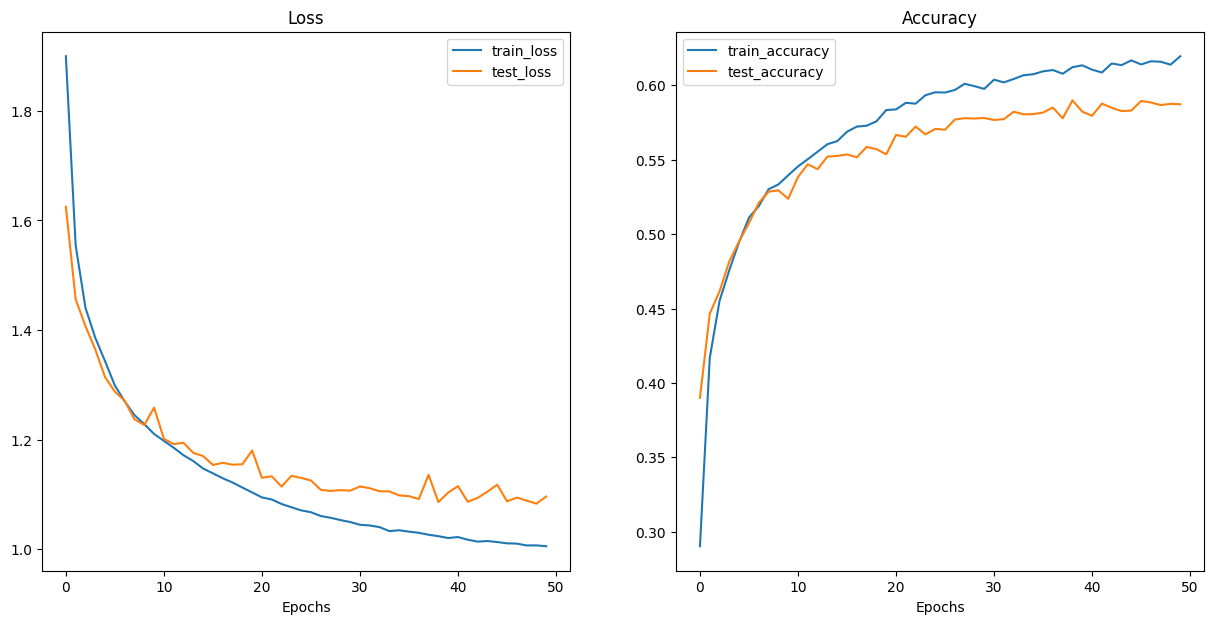

In [42]:
plot_loss_curves(model_relu_3_conv_layers_1_fc_results)

## Attacking the model

In [6]:
epsilons = torch.arange(0, 0.5, 0.0625)
epsilons

tensor([0.0000, 0.0625, 0.1250, 0.1875, 0.2500, 0.3125, 0.3750, 0.4375])

## FGSM Attack

𝑝𝑒𝑟𝑡𝑢𝑟𝑏𝑒𝑑_𝑖𝑚𝑎𝑔𝑒=𝑖𝑚𝑎𝑔𝑒+𝑒𝑝𝑠𝑖𝑙𝑜𝑛∗𝑠𝑖𝑔𝑛(𝑑𝑎𝑡𝑎_𝑔𝑟𝑎𝑑)=𝑥+𝜖∗𝑠𝑖𝑔𝑛(∇𝑥𝐽(𝜃,𝐱,𝑦))

Finally, in order to maintain the original range of the data, the perturbed image is clipped to range  [0,1].

In [17]:
# FGSM attack
def fgsm_attack(image: torch.Tensor, epsilon:torch.Tensor, data_grad:torch.Tensor) -> torch.Tensor:
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

## Testing the attack

In [ ]:
def test_model_on_attack(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    epsilon: float,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    device: str
    ):
    """
    Desc:
      funtion to perform testing step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): testing dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      epsilon (float): epsilon value for FGSM attack
      device (str): Torch Device "CPU/GPU"
    Returns:
      test_loss (float), test_acc (float): testing loss and testing accuracy for one EPOCH
    """
    model.eval() # putting model in eval model

    test_loss, test_acc = 0, 0 # initlizing loss and acc. for the epoch
    attacked_examples = [] # initlizing list to store attacked examples
    
    for (X,y) in dataloader: # loop in batches
      X,y = X.to(device), y.to(device) # sending the data to target device
      # print(f"shape of X: {X.shape}, shape of y: {y.shape}")
      # Set requires_grad attribute of tensor. Important for Attack
      X.requires_grad = True

      # Forward pass the X through the model
      y_pred_logits = model(X)
      init_pred = y_pred_logits.argmax(dim=1) # get the index of the max log-probability

      # If the initial prediction is wrong, dont bother attacking, just move on
      if (init_pred != y).all():
          continue
      
      # 1. forward pass
      y_pred_logits = model(X)

      # 2. calculate the loss
      loss = loss_fn(y_pred_logits, y)
      test_loss += loss.item()
      # Zero all existing gradients
      model.zero_grad()
      
      # Calculate gradients of model in backward pass
      loss.backward()

      # Collect datagrad
      data_grad = X.grad.data
      
      # attack the image
      perturbed_X = fgsm_attack(X, epsilon, data_grad)
      
      # re-classify the perturbed image
      y_pred_logits = model(perturbed_X)
      
      final_pred = y_pred_logits.argmax(dim=1) # get the index of the max log-probability

      # If the initial prediction is wrong, dont bother attacking, just move on
      if (final_pred != y).any():
        # print(f"preds: {final_pred}\n actual: {y}")
        # add the attacked example to the list
        idx = 0
        for i,j in zip(final_pred,y):
          if i != j:
            attacked_examples.append((epsilon, X[idx].cpu().detach(), perturbed_X[idx].cpu().detach(), init_pred[idx], final_pred[idx], y[idx]))
          idx += 1
      # 3. calculating accuracy
      test_acc += acc_fn(y_pred_logits.argmax(dim = 1), y).item()

    # 6. returning actual loss and acc.
    return test_loss/len(dataloader), test_acc/len(dataloader), attacked_examples

In [ ]:
attacked_examples_dict = {}
for epsilon in epsilons:
    test_loss,test_acc,attacked_examples = test_model_on_attack(
        model=model_relu_3_conv_layers_1_fc_50_epochs,
        dataloader=test_dataloader,
        acc_fn=acc_fn,
        loss_fn=loss_fn,
        device=device,
        epsilon=epsilon
    )
    attacked_examples_dict[epsilon.item()] = attacked_examples
    print(f"Attacked Examples: {len(attacked_examples)}")
    print(f"test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f} | epsilon: {epsilon:.4f}")

Attacked Examples: 3752
test_loss: 1.0692 | test_acc: 0.6029 | epsilon: 0.0000
Attacked Examples: 9682
test_loss: 1.0692 | test_acc: 0.0310 | epsilon: 0.0625
Attacked Examples: 9466
test_loss: 1.0692 | test_acc: 0.0521 | epsilon: 0.1250
Attacked Examples: 9336
test_loss: 1.0692 | test_acc: 0.0641 | epsilon: 0.1875
Attacked Examples: 9296
test_loss: 1.0692 | test_acc: 0.0680 | epsilon: 0.2500
Attacked Examples: 9296
test_loss: 1.0692 | test_acc: 0.0689 | epsilon: 0.3125
Attacked Examples: 9265
test_loss: 1.0692 | test_acc: 0.0730 | epsilon: 0.3750
Attacked Examples: 9249
test_loss: 1.0692 | test_acc: 0.0737 | epsilon: 0.4375


## Plotting the attacked examples

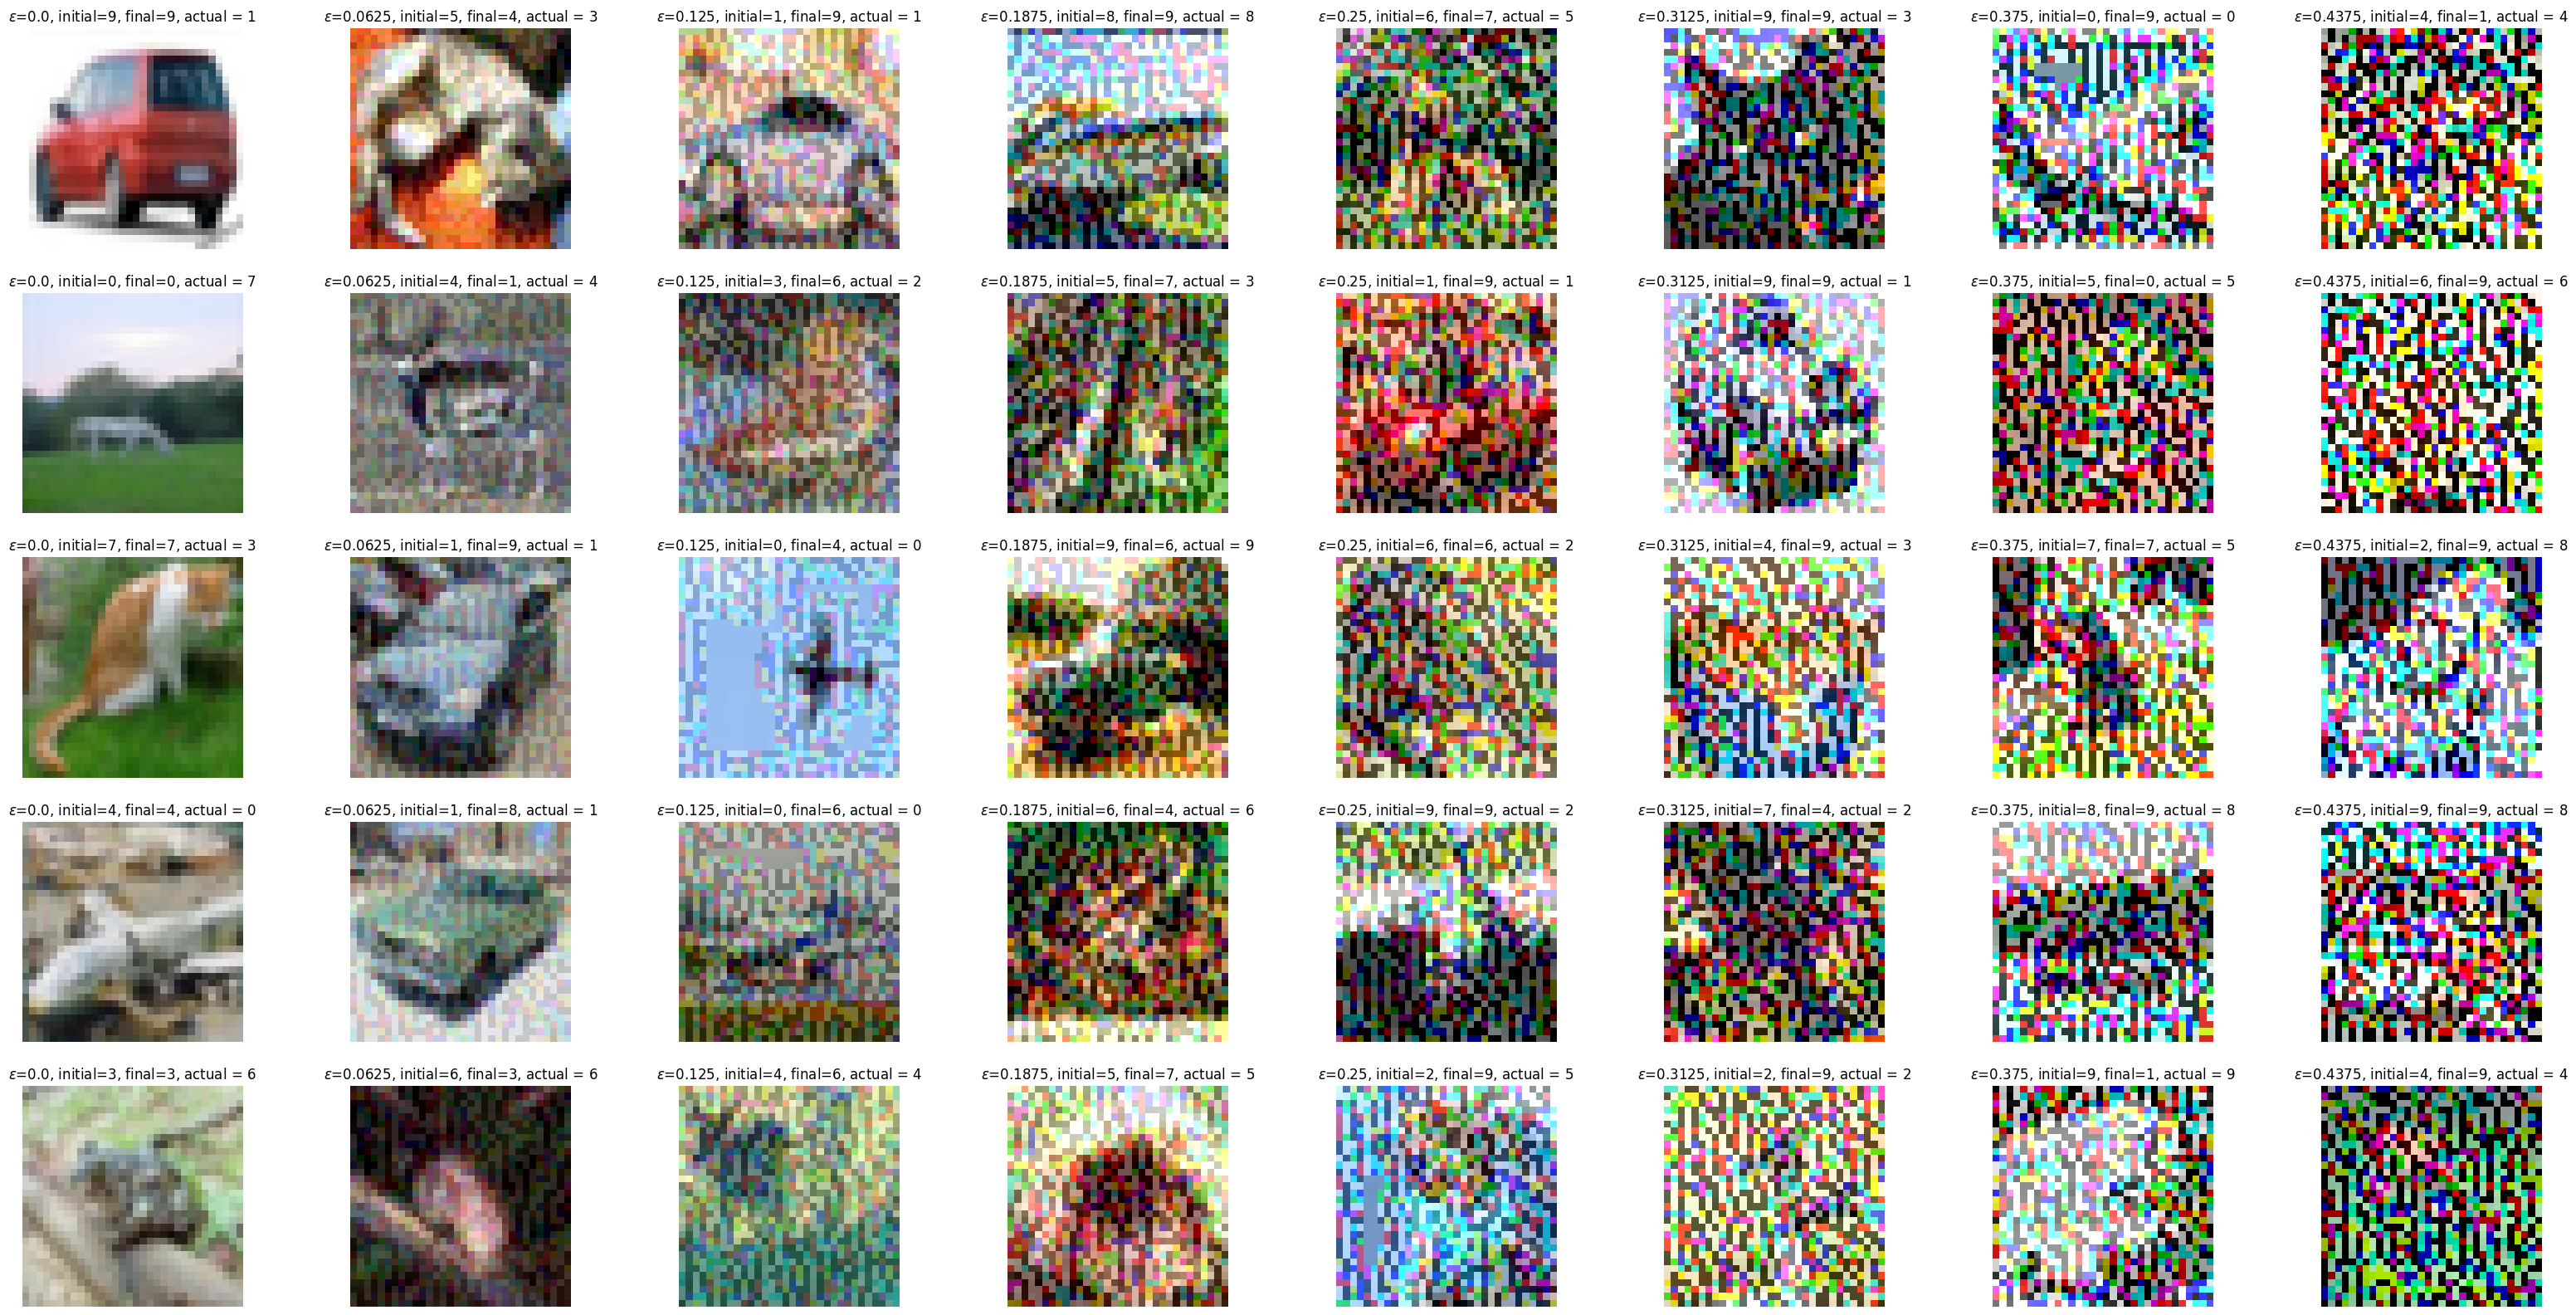

In [ ]:
plt.figure(figsize=(40,20))
rows = 5
for j in range(rows):
    for i in range(len(epsilons)):
        plt.subplot(rows, len(epsilons), i + j*len(epsilons) + 1)
        random_idx = np.random.randint(0, len(attacked_examples_dict[epsilons[i].item()]))
        random_sample = attacked_examples_dict[epsilons[i].item()][random_idx]
        plt.title(fr"$\epsilon$={epsilons[i]}, initial={random_sample[3]}, final={random_sample[4]}, actual = {random_sample[5]}")
        # print(random_sample[2].shape,random_sample[4])
        plt.imshow(random_sample[2].permute(1,2,0))
        plt.axis("off")
plt.show()